In [1]:
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers import  MaxPooling2D, Concatenate, Input, concatenate, add, multiply, maximum, BatchNormalization
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


Using TensorFlow backend.
/home/surya/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import shuffle 
import cv2
import numpy as np
import time
from os import listdir

%matplotlib inline

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename, cv2.IMREAD_GRAYSCALE)
            # crop the brain and ignore the unnecessary rest part of the image
            #image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
def createNegative(arr):
    X_neg = []
    for image in arr:
        negative = 255 - image
        X_neg.append(image)
    X_neg = np.array(X_neg)

    return X_neg

In [7]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
def build_model(input_shape):

    image_input = Input(shape = input_shape)
    padding = ZeroPadding2D((2, 2))(image_input)
    
    conv1 = Convolution2D(32, (7, 7),strides = (1,1), name = 'conv1')(padding)
    bn1 = BatchNormalization(axis = 3, name = 'bn1')(conv1)
    act1 = Activation('relu')(bn1)
    maxpool1 = MaxPooling2D((4, 4), name = 'max_pool1')(act1)

    conv2 = Convolution2D(32, (3, 3),strides = (1,1), name = 'conv2')(maxpool1)
    bn2 = BatchNormalization(axis = 3, name = 'bn2')(conv2)
    act2 = Activation('relu')(bn2)
    maxpool2 = MaxPooling2D((2,2), name = 'maxpool2')(act2)

    maxpool3 = MaxPooling2D((2,2), name = 'maxpool3')(maxpool2)

    flatten = Flatten()(maxpool3)


    neg_image_input = Input(shape = input_shape)
    neg_padding = ZeroPadding2D((2, 2))(neg_image_input)
    
    neg_conv1 = Convolution2D(32, (7, 7),strides = (1,1), name = 'neg_conv1')(neg_padding)
    neg_bn1 = BatchNormalization(axis = 3, name = 'neg_bn1')(neg_conv1)
    neg_act1 = Activation('relu')(neg_bn1)
    neg_maxpool1 = MaxPooling2D((4, 4), name = 'neg_max_pool1')(neg_act1)

    neg_conv2 = Convolution2D(32, (3, 3),strides = (1,1), name = 'neg_conv2')(neg_maxpool1)
    neg_bn2 = BatchNormalization(axis = 3, name = 'neg_bn2')(neg_conv2)
    neg_act2 = Activation('relu')(neg_bn2)
    neg_maxpool2 = MaxPooling2D((2,2), name = 'neg_maxpool2')(neg_act2)

    neg_maxpool3 = MaxPooling2D((2,2), name = 'neg_maxpool3')(neg_maxpool2)

    neg_flatten = Flatten()(neg_maxpool3)

    concat = Concatenate(axis = 1)([flatten, neg_flatten])
    output = Dense(1, activation = 'sigmoid', name = 'fc')(concat)

    model = Model(inputs = [image_input, neg_image_input], outputs = output, name = 'BrainTumorDetectionModel')

    return model

In [9]:
augmented_path = './Brain-MRI-augmented-data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240)
y shape is: (2065, 1)


In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240)
Y_test shape: (310, 1)


In [12]:
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)
X_val = np.expand_dims(X_val, axis = 3)

In [13]:
neg_X_train = createNegative(X_train)
neg_X_val = createNegative(X_val)
neg_X_test = createNegative(X_test)

In [14]:
image_shape = (IMG_WIDTH, IMG_HEIGHT, 1)
model = build_model(image_shape)
model.summary()

W0902 22:49:21.156016 140087862785856 deprecation_wrapper.py:119] From /home/surya/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 22:49:21.466460 140087862785856 deprecation_wrapper.py:119] From /home/surya/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 22:49:21.586364 140087862785856 deprecation_wrapper.py:119] From /home/surya/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 22:49:21.698878 140087862785856 deprecation_wrapper.py:119] From /home/surya/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 244, 244, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 244, 244, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Con

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

W0902 22:49:31.340127 140087862785856 deprecation_wrapper.py:119] From /home/surya/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0902 22:49:31.384603 140087862785856 deprecation.py:323] From /home/surya/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
checkpoint = ModelCheckpoint("./models/{}.hdf5".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [137]:
model.fit(x=[X_train, neg_X_train], y=y_train, batch_size=32, epochs=50, validation_data=([X_val, neg_X_val], y_val), callbacks=[checkpoint])

Train on 1445 samples, validate on 310 samples
Epoch 1/50
1445/1445 [==============================] - 7s 5ms/step - loss: 0.8060 - acc: 0.6851 - val_loss: 0.5991 - val_acc: 0.7452
Epoch 2/50
1445/1445 [==============================] - 6s 4ms/step - loss: 0.4855 - acc: 0.7626 - val_loss: 0.4897 - val_acc: 0.7774
Epoch 3/50
1445/1445 [==============================] - 6s 4ms/step - loss: 0.3809 - acc: 0.8166 - val_loss: 0.4796 - val_acc: 0.7871
Epoch 4/50
1445/1445 [==============================] - 6s 4ms/step - loss: 0.3336 - acc: 0.8547 - val_loss: 0.5111 - val_acc: 0.7548
Epoch 5/50
1445/1445 [==============================] - 6s 4ms/step - loss: 0.2648 - acc: 0.8844 - val_loss: 0.8538 - val_acc: 0.6677
Epoch 6/50
1445/1445 [==============================] - 6s 4ms/step - loss: 0.2340 - acc: 0.9010 - val_loss: 0.7745 - val_acc: 0.6968
Epoch 7/50
1445/1445 [==============================] - 6s 4ms/step - loss: 0.3343 - acc: 0.8512 - val_loss: 0.6052 - val_acc: 0.7677
Epoch 8/50
1445

In [0]:
history = model.history.history

In [139]:
for key in history.keys():
    print(key)

val_loss
val_acc
loss
acc


In [0]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

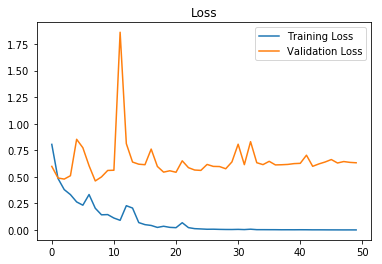

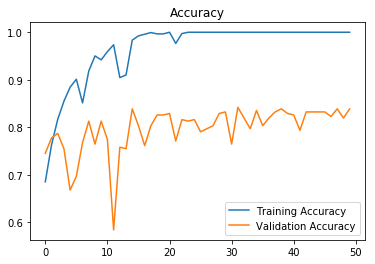

In [141]:
plot_metrics(history)

In [0]:
model = build_model([IMG_WIDTH, IMG_HEIGHT, 1])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights('./models/cnn-parameters-improvement-48-0.84.hdf5')

In [144]:
loss, acc = model.evaluate(x = [X_test, neg_X_test], y = y_test)

310/310 [==============================] - 1s 3ms/step


In [145]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.544662425210399
Test Accuracy = 0.864516128647712


In [0]:
np.save('data/test_images.npy', X_test)
np.save('data/test_labels.npy', y_test)

In [17]:
X_test = np.load('data/test_images.npy')
y_test = np.load('data/test_labels.npy')